# Macro Level Analysis: The evolution of the System with Time

In the first part of the analysis we will focus on how the global capabilities change with time. 

### Table of Contents

- [1.Characterisation of Years](#one)
    - [1.1.Years in the database](#one-one)
    - [1.2.Capability Matrixes of years](#one-two)
        - [1.2.1.Getting the labels](#one-two-one)
        - [1.2.2.Function](#one-two-two)
    - [1.3.Year profiles](#one-three)
- [2.Year Correlation Matrix](#two)
    - [2.1.Considerations](#two-one)
    - [2.2.Final Year Correlation Matrix](#two-two)
    - [2.3.Year correlation matrix clustering](#two-three)
- [3.Correlation of years over time](#three)
- [4.Research terms over time](#four)
    - [4.1.Evolution of output terms](#four-one)
    - [4.2.Evolution of processing technology terms](#four-two)
    - [4.3.Evolution of feedstock terms](#four-three)
- [5.Contextual relationships](#five)
    - [5.1.Oil](#five-one)
    - [5.2.Sugar](#five-two)
- [6. Comparing Years](#six)
    - [6.1.Visualizing the differences](#six-one)
    - [6.2.Understanding the differences](#six-two)

## 1. Characterisation of Years <a class="anchor" id="one"></a>

Let's start by importing all of the external libraries that will be useful during the analysis. 

In [1]:
# python libraries
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
import operator
from IPython.display import display, HTML
from matplotlib.colors import ListedColormap


# connection to Neo4j
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

# plotly credentials
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

### 1.1. Years in the database <a class="anchor" id="one-one"></a>

Not all years in the Neo4j database contain technological assets. For this reason, two lists will be created. A completely chronological one and a database one. 

In [2]:
# query years
years_available_q = """     MATCH (n:Asset)
                            WITH n.year as YEAR
                            RETURN YEAR, count(YEAR)
                            ORDER BY YEAR ASC """

# create a list with the years where records exist
years_available = DataFrame(connection_to_graph.data(years_available_q)).as_matrix()[:, 0][:-1]
years_available = [int(year) for year in years_available]

# create a pure range list
first_year = int(years_available[0])
last_year = int(years_available[-1])
real_years = range(first_year, last_year + 1, 1)

# give information 
print 'The database list starts in {}, ends in {} and contains {} years.'.format(years_available[0], years_available[-1], len(years_available))
print 'The real list starts in {}, ends in {} and contains {} years.'.format(real_years[0], real_years[-1], len(real_years))

The database list starts in 1938, ends in 2019 and contains 38 years.
The real list starts in 1938, ends in 2019 and contains 82 years.


Now that we have all of the years available, we can start building the technological capability matrixes.

### 1.2. Capability Matrixes of years <a class="anchor" id="one-two"></a>

#### 1.2.1. Getting the labels <a class="anchor" id="one-two-one"></a>

In [3]:
f_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
o_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:Output) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
pt_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:ProcessingTech) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
bbo = list(set(f_terms + pt_terms + o_terms))
print len(bbo)
axis_names = bbo

352


The final list of terms has 352 terms. 

#### 1.2.2. Function <a class="anchor" id="one-two-two"></a>

We start by creating a function that given a certain year, returns the year's capability matrix. 

In [4]:
def get_year_matrix(year, normalization=True):
    
    # define queries
    # non intersecting part
    q1 =         """    
                MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                WHERE a.year = "{}"
                RETURN fs.term, pt.term, out.term, count(a)
                """.format(year)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    # interesecting part
    q2 =        """    
                MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                WHERE fs<>t AND a.year = "{}"
                RETURN fs.term, t.term, count(a)
                """
    # total assets of year
    q3 =        """
                MATCH (n:Asset)
                WITH n.year as YEAR
                RETURN YEAR, count(YEAR)
                ORDER BY YEAR ASC
                """
    
    # treat incoming data
    raw_data_q3 = DataFrame(connection_to_graph.data(q3)).as_matrix()
    index_of_year = list(raw_data_q3[:, 0]).index('{}'.format(year))
    total_documents = raw_data_q3[index_of_year, 1]

    # get data
    data_q1 = DataFrame(connection_to_graph.data(q1)).as_matrix()
    
    # create matrix
    year_matrix = np.zeros([len(axis_names), len(axis_names)])
    
    # for no intersections data
    for row in data_q1:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [axis_names.index(element) for element in row[1::]]
        # add frequency value to matrix position not inter
        for pair in itertools.combinations(indexes, 2):
            year_matrix[pair[0], pair[1]] += frequency
            year_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(q2.format(category, category, year))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [axis_names.index(element) for element in row[1::]]
            # add frequency value to matrix position inter
            for pair in itertools.combinations(indexes, 2):
                year_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                year_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    norm_year_matrix = year_matrix  / total_documents
    
    # dynamic return 
    if normalization == True:
        return norm_year_matrix
    else: 
        return year_matrix

We finally test our function with the year 2016. 

In [5]:
year = 2017
print 'The matrix from {} has shape {} a max value of {}, a min value of {} and a mean of {}.'.format(year, get_year_matrix(year).shape, np.amax(get_year_matrix(year)), np.amin(get_year_matrix(year)), np.mean(get_year_matrix(year)))

The matrix from 2017 has shape (352, 352) a max value of 0.229850746269, a min value of 0.0 and a mean of 0.000211213110583.


Let us print the capability matrices of 2016 normalized and absolute versions.

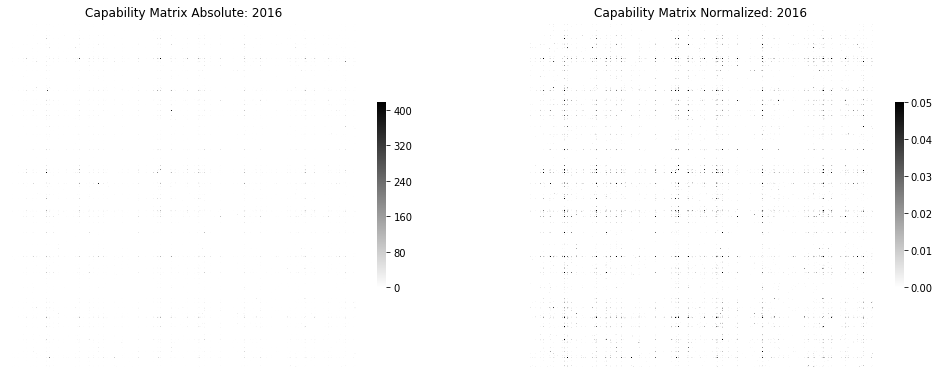

In [6]:
## call functions
colors = 'binary'

vmin = 0.0000
vmax = 0.05


year_in_focus = 2016
# create a subplot
plt.subplots(2,1,figsize=(17,17))

# first heatmap
plt.subplot(121)
sns.heatmap(get_year_matrix(year_in_focus, normalization=False) , cmap=colors,  cbar=True,cbar_kws={"shrink": .2}, square=True, xticklabels=False, yticklabels=False)
plt.title('Capability Matrix Absolute: {}'.format(year_in_focus))

# second heatmap
plt.subplot(122)
sns.heatmap(get_year_matrix(year_in_focus, normalization=True) , cmap=colors,  cbar=True,cbar_kws={"shrink": .2}, square=True, xticklabels=False, yticklabels=False, vmin=vmin, vmax=vmax)
plt.title('Capability Matrix Normalized: {}'.format(year_in_focus))
plt.show()



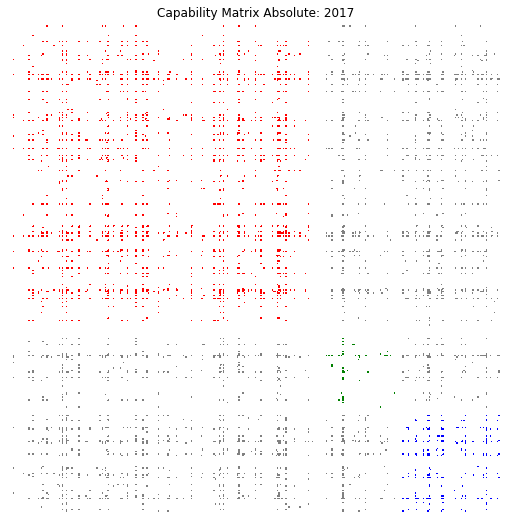

In [7]:
## call functions
color1 = 'Blues'
color3 = 'Reds'
rwhite = ListedColormap(['white', 'red'])
gwhite = ListedColormap(['white', 'green'])
blwhite = ListedColormap(['white', 'blue'])
bwhite = ListedColormap(['white', 'grey'])
year_in_focus = 2017
graph_holder = 0.001

original = get_year_matrix(year_in_focus, normalization=False)

threshold = len(f_terms)
f_mask = np.ones(original.shape)
f_mask[0:threshold, 0:threshold] = 0

threshold = len(f_terms) + len(pt_terms)
pt_mask = np.ones(original.shape)
pt_mask[len(f_terms):threshold , len(f_terms):threshold] = 0
o_mask = np.ones(original.shape)
o_mask[threshold:: , threshold::] = 0

plt.subplots(1,1,figsize=(9, 9))
plt.subplot(111)
sns.heatmap(original, cmap=bwhite, center=0.001, cbar=None, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(original, mask = f_mask, cmap=rwhite, center=graph_holder, cbar=None, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(original, mask = pt_mask, cmap=gwhite, center=graph_holder, cbar=None, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(original, mask = o_mask, cmap=blwhite, center=graph_holder, cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Capability Matrix Absolute: {}'.format(year_in_focus))
plt.show()

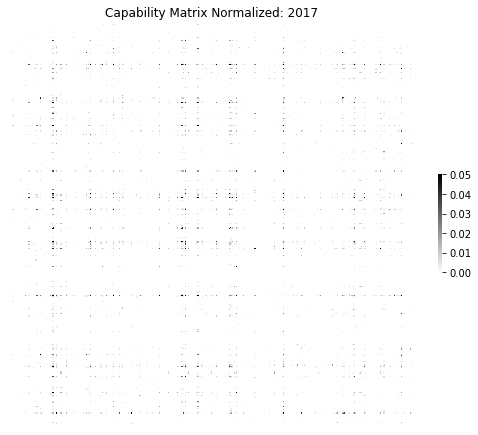

In [8]:
## call functions
colors = 'binary'
year_in_focus = 2017
# create a subplot

plt.subplots(1,1,figsize=(9, 9))
plt.subplot(111)
sns.heatmap(get_year_matrix(year_in_focus, normalization=True) , cmap=colors,  cbar=True,cbar_kws={"shrink": .2}, square=True, xticklabels=False, yticklabels=False, vmin=0.00, vmax=0.05)
plt.title('Capability Matrix Normalized: {}'.format(year_in_focus))
plt.show()

### 1.3. Year profiles <a class="anchor" id="one-three"></a>

In order to analyse the correlation of the years between themselves, we will need to transform each year matrix into a list. Since the matrix is symmetrical, we will only need the upper triangle. For control purposes, we have designed our own upper triangulization matrix. 

In [9]:
def get_list_from(matrix):
    only_valuable = []
    extension = 1
    for row_number in range(matrix.shape[0]):
        only_valuable.append(matrix[row_number, extension:matrix.shape[0]].tolist()) # numpy functions keep 0s so I hard coded it. 
        extension += 1 
    return [element for column in only_valuable for element in column ]

Let us print the capability lists of two example years. 

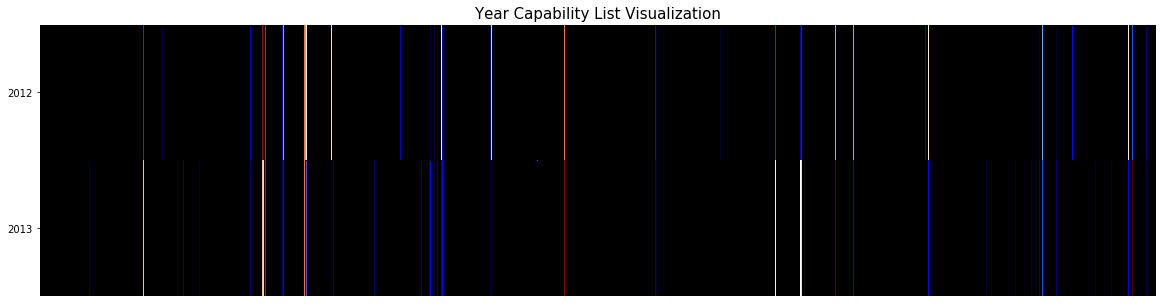

In [10]:
# apply functions to both countries
a_list = get_list_from(get_year_matrix(2012, normalization=True))
b_list = get_list_from(get_year_matrix(2013, normalization=True))

# create a matrix where each row is a list of a country
corelation = np.vstack((a_list, b_list))

# plot the matrix 
plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(corelation, cmap='flag_r', cbar=None, square=False, yticklabels=['2012', '2013'], xticklabels=False)
plt.yticks(rotation=0)
plt.title('Year Capability List Visualization', size=15)
plt.show()

It is already apparent that these two consecutive years are highly correlated.

## 2. Year Correlation Matrix <a class="anchor" id="two"></a>

### 2.1. Considerations <a class="anchor" id="two-one"></a>

As previously done with countries, a year correlation matrix will be built. 

We first define the scope of the matrix, by defining which years will be analyzed. 

In [11]:
number_of_years = len(years_available)
years_in_matrix = years_available
years_correlation = np.zeros([number_of_years, number_of_years])
print years_in_matrix

[1938, 1975, 1980, 1981, 1983, 1985, 1986, 1988, 1989, 1990, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


By looping over each year and calculating its capability list, we create a correlation matrix. 

In [12]:
data = np.load('Data/year_capability_dict.npy').item()
# for every year A
for row in range(number_of_years):
    year_1_list = data[years_in_matrix[row]] # get its capability list
    
    # for every year B
    for column in range(number_of_years):
        year_2_list = data[years_in_matrix[column]] # get its capability list
        years_correlation[row, column] = stats.pearsonr(year_1_list, year_2_list)[0] # calculate the correlation between the two and place it in the matrix

We now print the correlation matrix. 

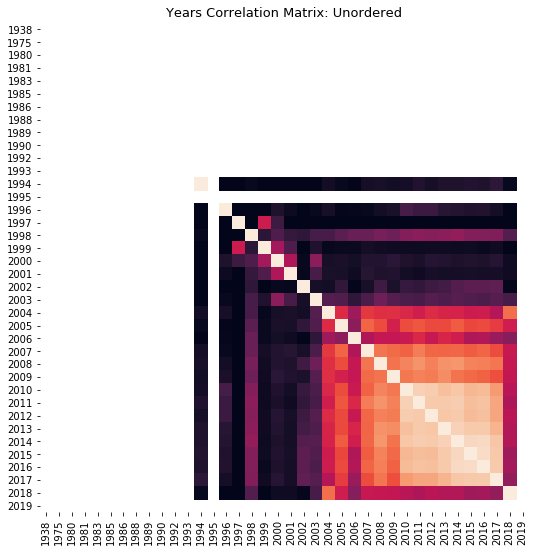

In [13]:
plt.subplots(1,1,figsize=(9, 9))
plt.subplot(111)
sns.heatmap(years_correlation, cbar=False, square=True, yticklabels=years_in_matrix, xticklabels=years_in_matrix)
plt.title('Years Correlation Matrix: Unordered', size=13)
plt.show()

There seems to be a lot of data missing. 

Let's plot the amount of records in our databse over time to get a better sense on how to approach the problem.

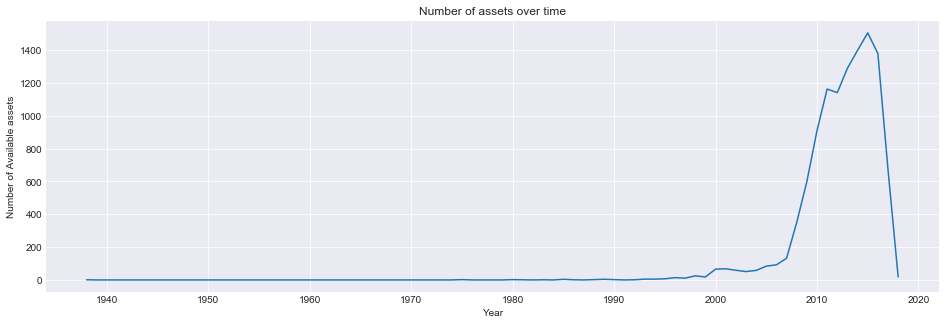

In [14]:
# get all of the data
data = DataFrame(connection_to_graph.data(years_available_q)).as_matrix()
raw = [int(a) for a in data[:-1, 0]]
timeline = range(min(raw), max(raw))
qtties = []

# build a timeline and number of records. 
for year in timeline:
    if year not in raw:
        qtties.append(0)
    else: 
        idx = list(data[:, 0]).index(str(year))
        qtties.append(data[idx, 1])

# re arrange it
amountOfRecords = np.column_stack((timeline, qtties))

# plot the graph
plt.style.use('seaborn-darkgrid')
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.title("Number of assets over time")
plt.xlabel("Year")
plt.ylabel("Number of Available assets")
plt.plot(timeline, qtties)
plt.show()

### 2.2. Final Year Correlation Matrix <a class="anchor" id="two-two"></a>

To counteract the fact that our dataset is not uniformily distributed across the years, we will only consider the last 15 years. [2004-2018]

In [15]:
number_of_years = 22
years_in_matrix = years_available[:-1][-number_of_years:]
years_correlation = np.zeros([number_of_years, number_of_years])

We now rebuild and plot the heatmap of correlations. 

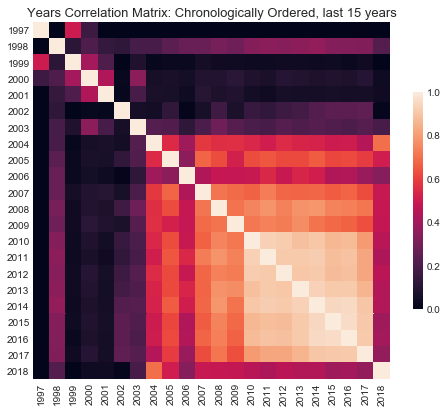

In [16]:
data = np.load('Data/year_capability_dict.npy').item() # for efficiency

# create the matrix again. 
for row in range(number_of_years):
    year_1_list = data[years_in_matrix[row]]
    for column in range(number_of_years):        
        year_2_list = data[years_in_matrix[column]]
        years_correlation[row, column] = stats.pearsonr(year_1_list, year_2_list)[0]

# print it
plt.subplots(1,1,figsize=(8, 8))
plt.subplot(111)
sns.heatmap(years_correlation, cbar=True, cbar_kws={"shrink": .5},square=True, yticklabels=years_in_matrix, xticklabels=years_in_matrix)
plt.title('Years Correlation Matrix: Chronologically Ordered, last 15 years', size=13)
plt.show()

### 2.3. Year correlation matrix clustering <a class="anchor" id="two-three"></a>

Let us reorder the heatmap according to hierarchical clustering. 

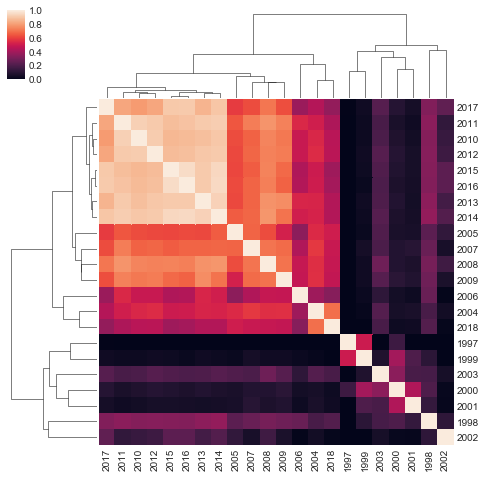

In [17]:
# plot the clustermap
a = sns.clustermap(years_correlation,  figsize=(8, 8), xticklabels = years_in_matrix, yticklabels=years_in_matrix)
plt.show()

## 3. Correlation of years over time <a class="anchor" id="three"></a>

Let us see how related is each year in our matrix with the one before it. In this way we might more easily detect discripancies. 

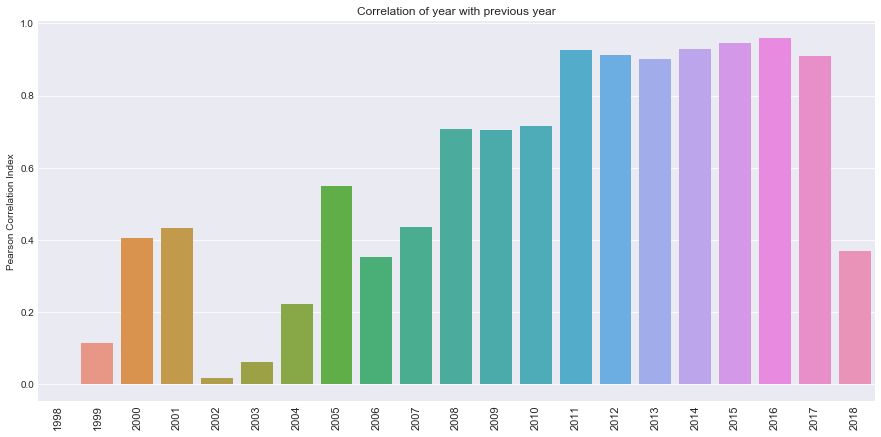

In [18]:
# remove first year
advanced_timeline = years_in_matrix[1::]
corr_with_pre = []

# iterate years and see their correlation 
row = 1
col = 0
for year in advanced_timeline:
    corr_with_pre.append(years_correlation[row, col])
    row = row + 1
    col = col + 1

# plot
plt.subplots(1,1,figsize=(15,7))
sns.barplot(np.arange(len(corr_with_pre)), corr_with_pre )
plt.xticks(np.arange(len(corr_with_pre)), advanced_timeline, rotation=90, fontsize=11)
plt.title('Correlation of year with previous year')
plt.ylabel('Pearson Correlation Index')
plt.show()

Some years, such as 2006 or 2007 appear to have very low correlations with the years after. There seems to be an overall tendency of augmenting correlation with the years. 

## 4. Research terms over time <a class="anchor" id="four"></a>

The following part of the analysis wil focus on how certain process variables (Feedstocks, Processing Technologies and Outputs) evolve over time.

This can help in answering questions such as for example:

- Is the focus on a certain processing technology constant over time?
- Is this evolution correlated with other external factors? 

Let's start by creating a function such as: 

f(term, type of process variable) = [array with the number of records containing the term in each year]

In [19]:
from __future__ import division
def get_records_of(startYear, endYear, term, process_type):
    
    # make query    
    yearRangeQuery = """ MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                WHERE fs.term = "{}"
                AND (toInteger(a.year)>={} AND toInteger(a.year)<={}) 
                AND NOT a.year = "Null"
                RETURN  a.year, count(a)
                ORDER BY a.year   """.format(process_type, term, startYear, endYear)
    
    # extract matrix
    rawQuery = DataFrame(connection_to_graph.data(yearRangeQuery)).as_matrix()
    
    # create matrix to store years, docs and total docs
    normalTimeline = np.arange(startYear, endYear + 1)
    completeMatrix = np.transpose(np.vstack((normalTimeline, normalTimeline, normalTimeline, normalTimeline)))    
    completeMatrix[:, 1::] = 0 

    # add number of docs found by query to matrix
    for i in range(len(rawQuery[:, 0])):
        for j in range(len(completeMatrix[:, 0])):
            if int(rawQuery[i, 0]) == completeMatrix[j, 0]:
                completeMatrix[j, 1] = rawQuery[i, 1] 
    
    # add total number of docs in that year to matrix
    for i in range(len(completeMatrix[:, 0])):
        for j in range(len(amountOfRecords[:, 0])):
            if completeMatrix[i, 0] == amountOfRecords[j, 0]:
                completeMatrix[i, 2] = amountOfRecords[j, 1]

    # create a list of the normalized results 
    normalizedRecords = []
    for i in range(len(completeMatrix[:, 0])):
        if completeMatrix[i, 2] != 0:
            normalizedRecords.append(float(completeMatrix[i, 1])/float(completeMatrix[i, 2]))
        else:
            normalizedRecords.append(0)
         
    # return a dictionnary for easy access to all variables
    result = {}
    result['range']  = completeMatrix[:, 0].tolist()
    result['nominal'] = completeMatrix[:, 1].tolist()
    result['total'] = completeMatrix[:, 2].tolist()        
    result['normalized'] = normalizedRecords
    
    return result

Now that the function is built, we can plot virtually any evolution.  

### 4.1. Evolution of output terms <a class="anchor" id="four-one"></a>

Let us see the evolution of records of biogas Vs. ethanol as an example.

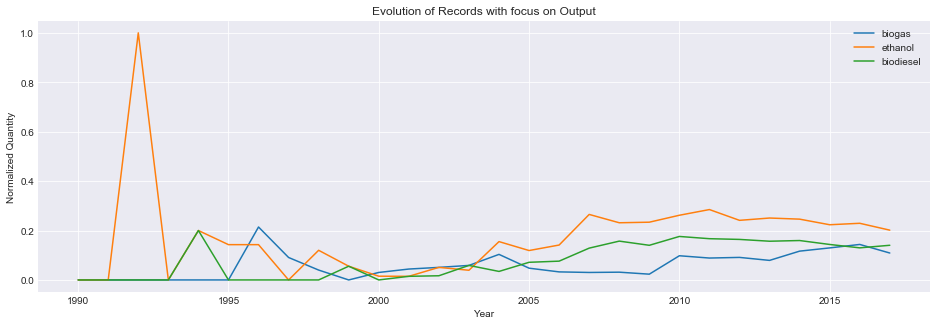

In [20]:
listOfOutputs = ['biogas', 'ethanol', 'biodiesel']
start_year = 1990
end_year = 2017

# plot the graph
plt.style.use('seaborn-darkgrid')
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.title("Evolution of Records with focus on Output")
plt.xlabel("Year")
plt.ylabel("Normalized Quantity")

for name in listOfOutputs:
    nameData = get_records_of(start_year,end_year,name, 'Output')
    plt.plot(nameData['range'], nameData['normalized'], label=name)

plt.legend()
plt.show()

### 4.2. Evolution of processing technology terms <a class="anchor" id="four-two"></a>

Let us develop the same procedure for some processing technologies.

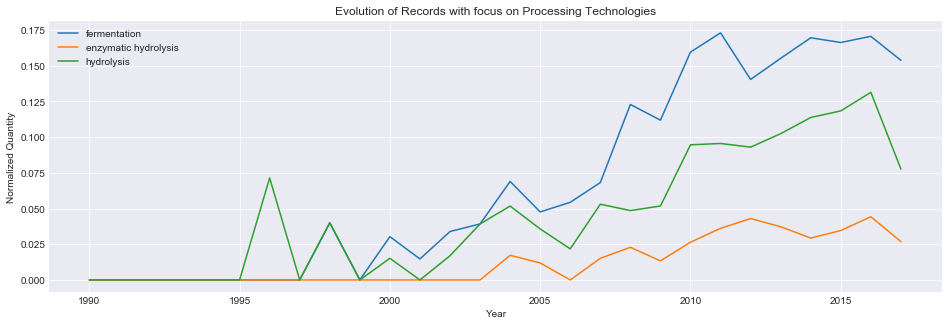

In [21]:
listOfProcTech = ['fermentation','enzymatic hydrolysis','hydrolysis' ]
start_year = 1990
end_year = 2017

# plot the graph
plt.style.use('seaborn-darkgrid')
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.title("Evolution of Records with focus on Processing Technologies")
plt.xlabel("Year")
plt.ylabel("Normalized Quantity")

for name in listOfProcTech:
    nameData = get_records_of(start_year,end_year,name, 'ProcessingTech')
    plt.plot(nameData['range'], nameData['normalized'], label=name)

plt.legend()
plt.show()

### 4.3. Evolution of feedstock terms <a class="anchor" id="four-three"></a>

Let us develop the same procedure for feedstock.

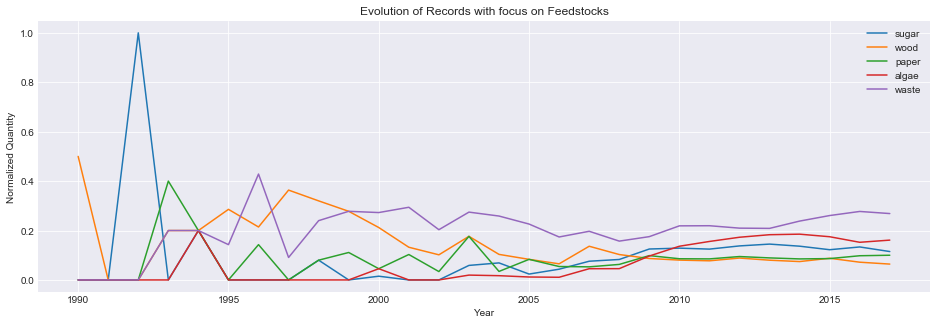

In [22]:
listOfFeed = ['sugar','wood','paper', 'algae', 'waste']
start_year = 1990
end_year = 2017

# plot the graph
plt.style.use('seaborn-darkgrid')
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.title("Evolution of Records with focus on Feedstocks")
plt.xlabel("Year")
plt.ylabel("Normalized Quantity")

for name in listOfFeed:
    nameData = get_records_of(start_year,end_year,name, 'Feedstock')
    plt.plot(nameData['range'], nameData['normalized'], label=name)

plt.legend()
plt.show()

## 5. Contextual relationships <a class="anchor" id="five"></a>

### 5.1. Oil <a class="anchor" id="five-one"></a>

We start by comparing the evolution of the outputs above studied with the average oil price per gallon found in the [following](https://fred.stlouisfed.org/series/GASREGCOVM#0) website.

We import the data, and convert monthly prices to yearly averages with the bellow code. 

- [Price per gallon in US dollars](https://fred.stlouisfed.org/series/GASREGCOVM#0)
- [Price per barrel inflation adjusted in US dollars](https://inflationdata.com/Inflation/Inflation_Rate/Historical_Oil_Prices_Table.asp)

In [23]:
# get price per gallon in US dollars
oil_data = pd.read_csv('Data/GasData.csv', delimiter=',', header=None).as_matrix()[1::, :]
gallon = []
oil_years = list(set([int(e[0:4]) for e in oil_data[:, 0]]))[:-1]
for year in oil_years:
    addition = 0
    months = 0
    for row in oil_data:
        if str(year) in row[0]:
            addition += float(row[1])
            months += 1
    average = addition / months
    gallon.append(average)

# get price per barrel data 
barrel = pd.read_csv('Data/GasDataNormalized.csv', delimiter=';', header=None).as_matrix()[:, 1].tolist()

oil_index = {'gallon':gallon, 'barrel':barrel}

**Relationship Over Time**

Let us visualize how the evolution of the price of gas relates to the normalized quantity of assets over time, in a chronological graph. 

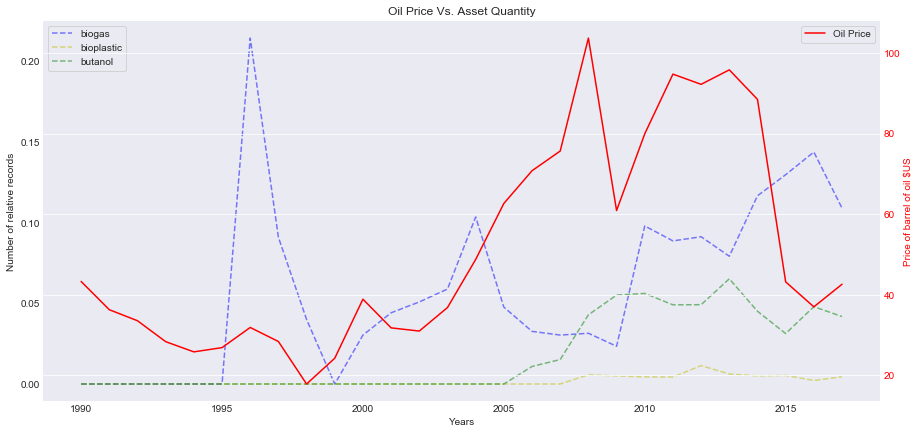

In [24]:
# define subplots
fig, ax1 = plt.subplots(figsize=(15,7))
listOfOutputs = ['biogas', 'bioplastic', 'butanol']
colors = ['b', 'y', 'g']
start_year = 1990
end_year = 2017
price_type = 'barrel'

# first axis

for position, outputName in enumerate(listOfOutputs):
    nameData = get_records_of(start_year, end_year, outputName, 'Output')
    ax1.plot(nameData['range'], nameData['normalized'], label=outputName, color=colors[position], ls='--', alpha=0.5) 
    

ax1.set_xlabel('Years')
ax1.set_ylabel('Number of relative records')
ax1.tick_params('y')
ax1.set_title('Oil Price Vs. Asset Quantity')
ax1.legend(loc=2, frameon=True)
ax1.grid(False)

# second axis
ax2 = ax1.twinx()
ax2.plot(oil_years,oil_index[price_type], color='r', label='Oil Price')
ax2.set_ylabel('Price of {} of oil $US'.format(price_type), color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc=1, frameon=True)

# expose
plt.show()

**Scatter Visualization**

To study this relationship in a more in depth fashion we create a process that given a certain term gives us the relationship with the price of gas. 

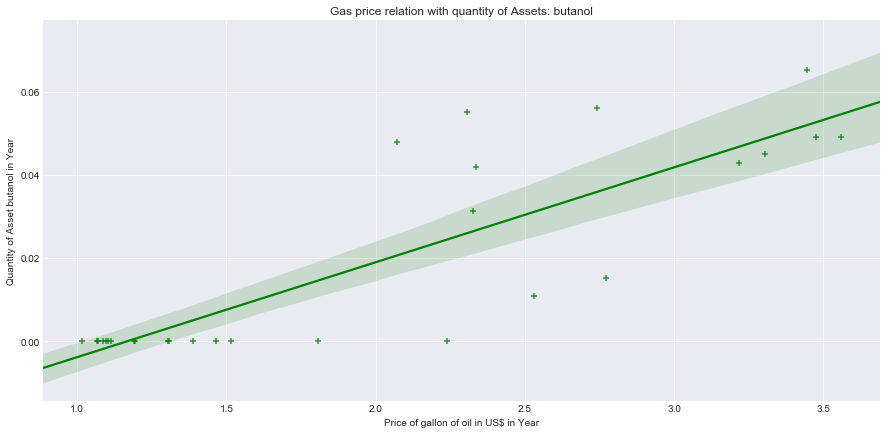

Pearson Correlation Index:  0.8445465111603638
P-value:  1.6031894575347735e-08


In [25]:
# define terms
outPutToCompare = 'butanol'
typeOfProcessVariable = 'Output'
price_type = 'gallon'

# get data
data = get_records_of(1990, 2017, outPutToCompare, typeOfProcessVariable)['normalized']

# plot the figure
fig, ax1 = plt.subplots(figsize=(15,7))
sns.regplot(np.asarray(oil_index[price_type]), np.asarray(data) ,fit_reg=True, marker="+", color = 'g')
plt.title('Gas price relation with quantity of Assets: {}'.format(outPutToCompare))
plt.xlabel('Price of {} of oil in US$ in Year'.format(price_type))
plt.ylabel('Quantity of Asset {} in Year'.format(outPutToCompare))
plt.show()

# get correlation indexes
correlationIndexes =  stats.pearsonr(np.asarray(oil_index[price_type]), np.asarray(get_records_of(1990, 2017, outPutToCompare, 'Output')['normalized']))
print 'Pearson Correlation Index: ', correlationIndexes[0]
print 'P-value: ', correlationIndexes[1]

In the above graph each datapoint corresponds to a year. 

**Biggest Positive Correlations**

In [26]:
# query for data
term_names_query = """  MATCH (a:Asset)-[:CONTAINS]->(fs:Output)
                        WHERE (toInteger(a.year)>=1990 AND toInteger(a.year)<=2017) 
                        AND NOT a.year = "Null"
                        RETURN  fs.term, count(a)
                        ORDER BY count(a) DESC"""

# get data from past scripts
oil_type = 'gallon'
term_names = list(DataFrame(connection_to_graph.data(term_names_query)).as_matrix()[:, 1].tolist())
correlations = []
p_values = []

# for every term, get its correlation with the price of oil
for term in term_names:
    data = get_records_of(1990, 2017, term, 'Output')['normalized']
    correlations.append(stats.pearsonr(data, oil_index[oil_type])[0])
    p_values.append(stats.pearsonr(data, oil_index[oil_type])[1])


# create a pandas dataframe for pretty printing. 
oilDataFrame = pd.DataFrame(
    {'Output Name': term_names,
     'Pearson Correlation Index': correlations,
     'P-value': p_values
    })
oilDataFrame = oilDataFrame.sort_values('Pearson Correlation Index', ascending=False)

# print context
print 'The relationship between relative number of documents and price of oil over time:'
top = 10

# print data
print 'TOP {}:'.format(top)
display(oilDataFrame[:top]) 

The relationship between relative number of documents and price of oil over time:
TOP 10:


,Output Name,P-value,Pearson Correlation Index
7,butanol,1.603189e-08,0.844547
19,bioplastic,2.463734e-07,0.804599
1,biodiesel,7.978637e-07,0.784034
21,fatty acid ethyl ester,1.427601e-06,0.772960
30,adipic acid,1.048009e-05,0.729790
3,bioethanol,2.862862e-05,0.704439
9,syng,3.649295e-05,0.697899
15,biobutanol,5.140385e-05,0.688369
8,cellulosic ethanol,1.301892e-04,0.660616
14,biopolymers,3.263515e-04,0.630094


**Biggest Negative Correlations**

In [27]:
# same approach but value negative correlations
term_names_query = """  MATCH (a:Asset)-[:CONTAINS]->(fs:Output)
                        WHERE (toInteger(a.year)>=1990 AND toInteger(a.year)<=2017) 
                        AND NOT a.year = "Null"
                        RETURN  fs.term, count(a)
                        ORDER BY count(a) DESC"""
oil_type = 'gallon'
term_names = list(DataFrame(connection_to_graph.data(term_names_query)).as_matrix()[:, 1].tolist())
correlations = []
p_values = []
for term in term_names:
    data = get_records_of(1990, 2017, term, 'Output')['normalized']
    correlations.append(stats.pearsonr(data, oil_index[oil_type])[0])
    p_values.append(stats.pearsonr(data, oil_index[oil_type])[1])

oilDataFrame = pd.DataFrame(
    {'Output Name': term_names,
     'Pearson Correlation Index': correlations,
     'P-value': p_values
    })
oilDataFrame = oilDataFrame.sort_values('Pearson Correlation Index', ascending=False)



print 'The relationship between relative number of documents and price of oil over time:'
bottom = -10

print 'BOTTOM {}:'.format(bottom)
display(oilDataFrame[bottom:]) 

The relationship between relative number of documents and price of oil over time:
BOTTOM -10:


,Output Name,P-value,Pearson Correlation Index
16,naphtha,0.677733,0.082145
44,biodiesel blending,0.683315,0.080645
45,ethanol blending,0.683315,0.080645
18,renewable diesel,0.716673,0.071767
11,renewable fuel,0.944557,0.013770
17,succinic acid,0.956893,0.010703
40,rdif,0.629618,-0.095276
34,electricity from biomass,0.456174,-0.146748
5,gasoline,0.371514,-0.175570
10,pellets,0.268436,-0.216520


### 5.2. Sugar <a class="anchor" id="five-two"></a>

In this part we will make the same analysis but taking an example of a feedstock: sugar. 

Data was obtained [here.](http://databank.worldbank.org/data/reports.aspx?source=global-economic-monitor-commodities#)

We start by importing the data. 

In [28]:
sugar_data = pd.read_csv('Data/Sugar_Price.csv', delimiter=';', header=None).as_matrix()
sugar = {}
sugar['years'] = [int(e) for e in sugar_data[:, 0]]
sugar['nominal'] = [e for e in sugar_data[:, 1]]
sugar['real'] =  [e for e in sugar_data[:, 2]]

**Relationship Over Time**

Let us see the evolution of Sugar prices side by side with the evolution of certain feedstocks in our database. 

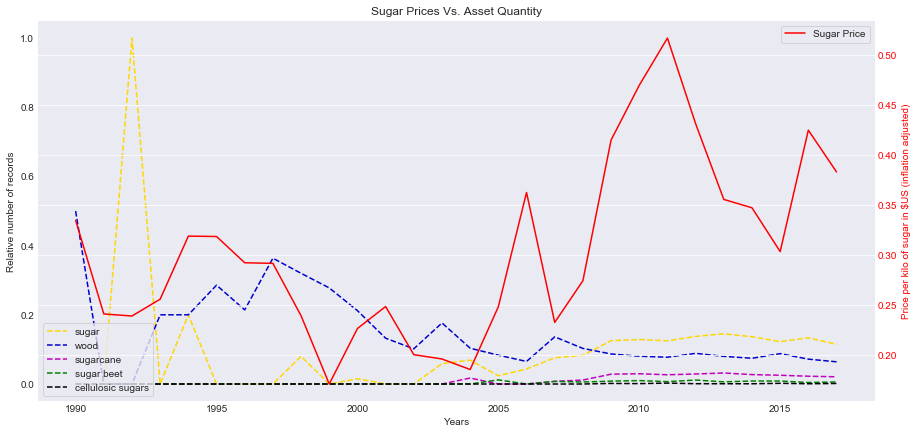

In [29]:
# define subplots
fig, ax1 = plt.subplots(figsize=(15,7))
feedstock_list = ['sugar', 'wood', 'sugarcane', 'sugar beet', 'cellulosic sugars']
colors = ['gold', 'mediumblue', 'm', 'green', 'k']

start_year = 1990
end_year = 2017
sugar_price_type = 'real'

# first axis
for position,feedstock in enumerate(feedstock_list):
    data = get_records_of(start_year, end_year, feedstock, 'Feedstock')
    ax1.plot(data['range'], data['normalized'], label=feedstock, ls='--', color=colors[position])
    
ax1.set_xlabel('Years')
ax1.set_ylabel('Relative number of records')
ax1.tick_params('y')
ax1.set_title('Sugar Prices Vs. Asset Quantity')
ax1.legend(loc=3, frameon=True)
ax1.grid(False)

# second axis
ax2 = ax1.twinx()
ax2.plot(sugar['years'], sugar[sugar_price_type], color='r', label='Sugar Price', ls='-')
ax2.set_ylabel('Price per kilo of sugar in $US (inflation adjusted)', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc=1, frameon=True)

# expose
plt.show()


**Scatter Example**

Let us see a scatter plot where each point is a year and the x and y axis correpond to the price of sugar and quantity of assets respectively. 

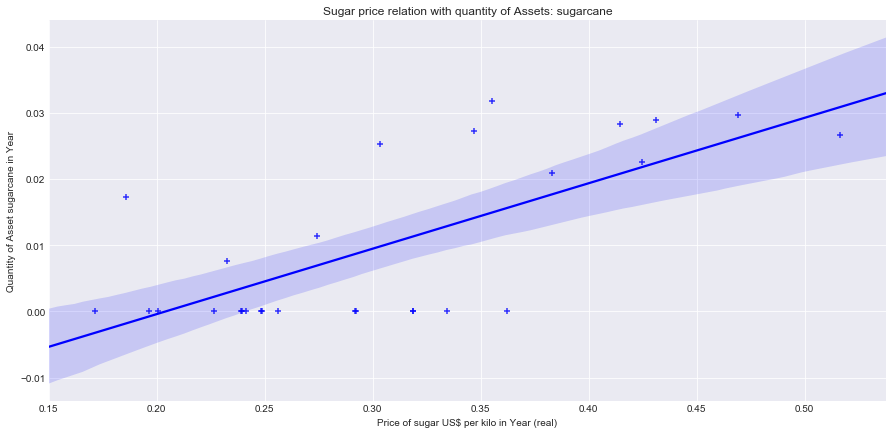

In [30]:
outPutToCompare = 'sugarcane'
typeOfProcessVariable = 'Feedstock'
price_type = 'real'


data = get_records_of(1990, 2017, outPutToCompare, typeOfProcessVariable)['normalized']

fig, ax1 = plt.subplots(figsize=(15,7))
sns.regplot(np.asarray(sugar[price_type]), np.asarray(data) ,fit_reg=True, marker="+", color = 'b')
plt.title('Sugar price relation with quantity of Assets: {}'.format(outPutToCompare))
plt.xlabel('Price of sugar US$ per kilo in Year ({})'.format(price_type))
plt.ylabel('Quantity of Asset {} in Year'.format(outPutToCompare))

plt.show()

**Biggest Positive Correlations**

Which are the feedstocks who are more related to the price of sugar per kilo in what regards the number of records? 

In [31]:
term_names_query = """  MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                        WHERE (toInteger(a.year)>=1990 AND toInteger(a.year)<=2017) 
                        AND NOT a.year = "Null"
                        RETURN  fs.term, count(a)
                        ORDER BY count(a) DESC"""
price_type = 'nominal'
term_names = list(DataFrame(connection_to_graph.data(term_names_query)).as_matrix()[:, 1].tolist())
correlations = []
p_values = []
for term in term_names:
    data = get_records_of(1990, 2017, term, 'Feedstock')['normalized']
    correlations.append(stats.pearsonr(data, sugar[price_type])[0])
    p_values.append(stats.pearsonr(data, sugar[price_type])[1])

sugarDataframe = pd.DataFrame(
    {'Feedstock Name': term_names,
     'Pearson Correlation Index': correlations,
     'P-value': p_values
    })
sugarDataframe = sugarDataframe.sort_values('Pearson Correlation Index', ascending=False)



print 'The relationship between relative number of documents and price per kilo of sugar:'
top = 10

print 'TOP {}:'.format(top)
display(sugarDataframe[:top]) 

The relationship between relative number of documents and price per kilo of sugar:
TOP 10:


,Feedstock Name,P-value,Pearson Correlation Index
26,sugarcane,6.074365e-07,0.789014
107,cellulosic sugars,1.263220e-06,0.775341
43,jatropha,1.521222e-06,0.771713
34,sorghum,3.083429e-06,0.757299
64,dry biomass,3.454736e-06,0.754884
75,beets,4.105286e-06,0.751165
99,dedicated energy crops,6.915371e-06,0.739525
1,algae,1.103076e-05,0.728562
100,hybrid poplar,1.490683e-05,0.721206
25,soy,2.631077e-05,0.706675


**Biggest Negative Correlations**


In [32]:
term_names_query = """  MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                        WHERE (toInteger(a.year)>=1990 AND toInteger(a.year)<=2017) 
                        AND NOT a.year = "Null"
                        RETURN  fs.term, count(a)
                        ORDER BY count(a) DESC"""
price_type = 'nominal'
term_names = list(DataFrame(connection_to_graph.data(term_names_query)).as_matrix()[:, 1].tolist())
correlations = []
p_values = []
for term in term_names:
    data = get_records_of(1990, 2017, term, 'Feedstock')['normalized']
    correlations.append(stats.pearsonr(data, sugar[price_type])[0])
    p_values.append(stats.pearsonr(data, sugar[price_type])[1])

sugarDataframe = pd.DataFrame(
    {'Feedstock Name': term_names,
     'Pearson Correlation Index': correlations,
     'P-value': p_values
    })
sugarDataframe = sugarDataframe.sort_values('Pearson Correlation Index', ascending=False)



print 'The relationship between relative number of documents and price per kilo of sugar:'
bottom = -10

print 'Bottom {}:'.format(bottom * -1)
display(sugarDataframe[bottom:]) 

The relationship between relative number of documents and price per kilo of sugar:
Bottom 10:


,Feedstock Name,P-value,Pearson Correlation Index
93,wood fuel,0.336664,-0.188530
72,waste oil,0.329527,-0.191282
136,particle board,0.289545,-0.207425
156,durum,0.279399,-0.211741
178,citrus residues,0.260452,-0.220080
123,beef tallow,0.240798,-0.229158
53,sawdust,0.223542,-0.237542
138,trap grease,0.212719,-0.243025
79,wood waste,0.210637,-0.244102
5,wood,0.137684,-0.287685


**NON SERIES TIME ANALYSIS IS A LIMITATION.**

## 6. Comparing Years <a class="anchor" id="six"></a>

In this part of the analysis the goal is two understand what exact capabilities differ from year to year. More exactly, how does one particular capability evolve over the course of two or more years. 

For example, if in year X1, Y1% of the assets related to sugar, what is the percentage Y2% in year X2? 

### 6.1. Visualizing the differences  <a class="anchor" id="six-one"></a>

Let us visualize two different years side by side. 

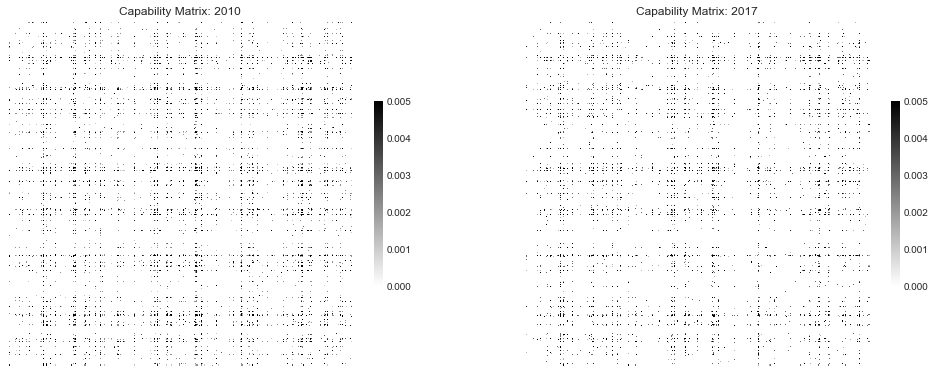

In [33]:
## call functions
first_year = 2010
second_year = 2017
colors='binary'

graph_holder = 0.005

fst_year_matrix = get_year_matrix(first_year, normalization=True)
scnd_year_matrix = get_year_matrix(second_year, normalization=True)

# create a subplot
plt.subplots(2,1,figsize=(17,17))

# first heatmap
plt.subplot(121)
sns.heatmap(fst_year_matrix , cmap=colors,  cbar=True,cbar_kws={"shrink": .2}, square=True, xticklabels=False, yticklabels=False, vmax=graph_holder)
plt.title('Capability Matrix: {}'.format(first_year))

# second heatmap
plt.subplot(122)
sns.heatmap(scnd_year_matrix , cmap=colors,  cbar=True,cbar_kws={"shrink": .2}, square=True, xticklabels=False, yticklabels=False, vmax=graph_holder)
plt.title('Capability Matrix: {}'.format(second_year))
plt.show()

Due to the very high number of rows, visualization is rather hard. 

The next step is to create a matrix of absolute diferences between the two examples, for this, we start by subtracting them:

In [34]:
cap_diff = np.absolute(fst_year_matrix - scnd_year_matrix)

And we plot these differences. 

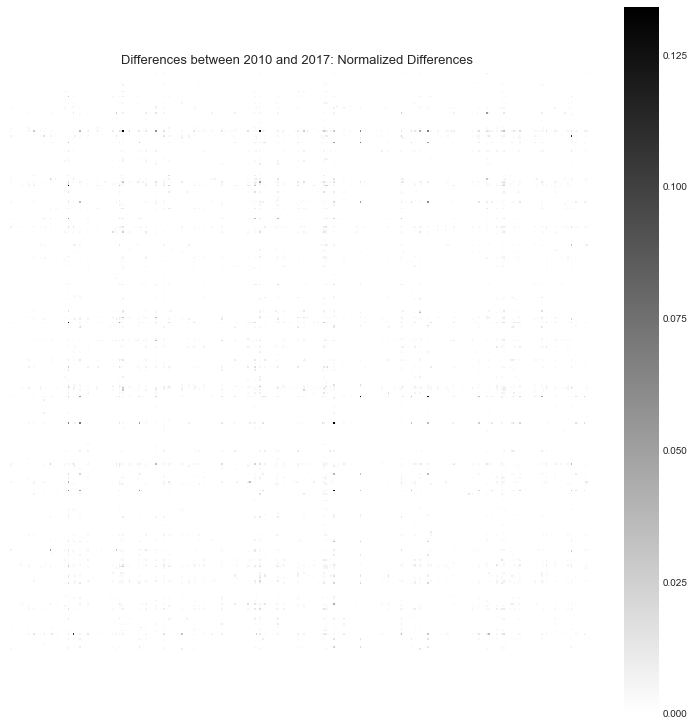

In [35]:
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(cap_diff, cmap=colors, square=True, yticklabels=False, xticklabels=False)
plt.title('Differences between {} and {}: Normalized Differences'.format(first_year, second_year), size=13)
plt.show()

There seem to be some areas where differences clearly exist. Let us investigate these areas in a more in depth fashion. 

### 6.2. Understanding the differences  <a class="anchor" id="six-two|"></a>

Let's understand what exact capability pairs are the most 'popular' in each year. 

We start by creating a function that returns given a year X, the most popular capability pairs of that year as absolute numbers and percentage of total documents. 

In [36]:
def get_top_hits(yearMatrix, year):
    """
    The function prints the top occurences if fed a matrix of occurences, it also prints other types of valuable info.
    WARNING: Percentages are shown as 0 to 1. 
    """
        
    # list where all the values and indexes of matrix are stored
    top = 10
    values = []
    indexes = []
    no_duplicates = np.triu(yearMatrix, 1)
    total_documents = np.sum(no_duplicates)
    matrix_axis_names = axis_names
    
    
    # loop through the matrix
    for row_n in range(yearMatrix.shape[0]):
        for col_n in range(yearMatrix.shape[1]):
            values.append(no_duplicates[row_n, col_n])
            indexes.append((row_n, col_n))
    
    
    # order the indexes and get the top
    Z = [indexes for _,indexes in sorted(zip(values,indexes))]
    extremes = Z[-top :]
    
    
    # create dataframe
    term_Dataframe = pd.DataFrame(
        {'First Term': [matrix_axis_names[e[0]] for e in extremes],
         'Second Term': [matrix_axis_names[e[1]] for e in extremes],
         'Number of Documents': [int(no_duplicates[e[0], e[1]]) for e in extremes], 
         'Percentage' : [no_duplicates[e[0], e[1]] / float(total_documents) for e in extremes], 
        })
    
    # prepare dataframe
    term_Dataframe = term_Dataframe[['First Term', 'Second Term','Number of Documents', 'Percentage']]
    term_Dataframe = term_Dataframe.sort_values('Number of Documents', ascending=False)
    
    
    # print everything
    print 'The top hits for the {} matrix: '.format(year)
    display(HTML(term_Dataframe.to_html(index=False)))
    
    
    print 'The total number of documents is {}.'.format(int(total_documents))
    print 'Note: Percentages are as 0-1 in this table. '

Let us use this function to try to understand each year.

Let us get the top term pairs for the year of 2017.

In [37]:
get_top_hits(fst_year_matrix, first_year)

The top hits for the 2010 matrix: 


First Term,Second Term,Number of Documents,Percentage
ethanol,cellulose,0,0.005873
hydrolysis,bioethanol,0,0.006563
fermentation,sugar,0,0.007047
ethanol,sugar,0,0.007323
bioethanol,fermentation,0,0.008291
biodiesel,catalysis,0,0.009051
anaerobic digestion,biogas,0,0.010502
biodiesel,transesterification,0,0.011607
ethanol,hydrolysis,0,0.015545
ethanol,fermentation,0,0.022040


The total number of documents is 15.
Note: Percentages are as 0-1 in this table. 


Let us get the top term pairs for the year of 2010.

In [38]:
get_top_hits(scnd_year_matrix, second_year)

The top hits for the 2017 matrix: 


First Term,Second Term,Number of Documents,Percentage
fermentation,biogas,0,0.006045
biogas,waste,0,0.006045
fermentation,sugar,0,0.006502
ethanol,waste,0,0.006616
ethanol,sugar,0,0.006844
ethanol,hydrolysis,0,0.008669
bioethanol,fermentation,0,0.008669
pyrolysis,bio-oil,0,0.011520
anaerobic digestion,biogas,0,0.015627
ethanol,fermentation,0,0.017566


The total number of documents is 13.
Note: Percentages are as 0-1 in this table. 


We can make two observations: 
- These two particular years have generally the same term pairs in their top table. 
- However, the percentages can differ greatly. 

*Note: There is a high difference in number of documents. *

Let us now finally create a side by side comparison. 

In [39]:
# list where all the values and indexes of matrix are stored
frst_perc = fst_year_matrix / np.sum(np.triu(fst_year_matrix, 1)) # half only  
scnd_perc = scnd_year_matrix / np.sum(np.triu(scnd_year_matrix, 1)) 
differences = frst_perc - scnd_perc
differences = np.absolute(differences)
values = []
indexes = []
no_duplicates = np.triu(differences, 1)
matrix_axis_names = axis_names


top = 20

# loop through the matrix
for row_n in range(differences.shape[0]):
    for col_n in range(differences.shape[1]):
        values.append(no_duplicates[row_n, col_n])
        indexes.append((row_n, col_n))

# print the table 
Z = [indexes for _,indexes in sorted(zip(values,indexes))]
extremes = list(reversed(Z[-top:]))


term_Dataframe = pd.DataFrame(
    {'First Term': [matrix_axis_names[e[0]] for e in extremes],
     'Second Term': [matrix_axis_names[e[1]] for e in extremes],
     '{} Percentage'.format(first_year): [frst_perc[e[0], e[1]] for e in extremes], 
     '{} Percentage'.format(second_year): [scnd_perc[e[0], e[1]] for e in extremes], 
     'Difference in %': [no_duplicates[e[0], e[1]] for e in extremes]
    })

term_Dataframe = term_Dataframe[['First Term', 'Second Term', '{} Percentage'.format(first_year), '{} Percentage'.format(second_year), 'Difference in %']]


display(HTML(term_Dataframe.to_html(index=False)))
print 'Percentages are as 0-1 in this table for easy viz.'

First Term,Second Term,2010 Percentage,2017 Percentage,Difference in %
pyrolysis,bio-oil,0.002625,0.011520,0.008895
biodiesel,transesterification,0.011607,0.003878,0.007729
biodiesel,catalysis,0.009051,0.001825,0.007226
ethanol,hydrolysis,0.015545,0.008669,0.006876
anaerobic digestion,biogas,0.010502,0.015627,0.005125
ethanol,anaerobic digestion,0.000553,0.005133,0.004580
ethanol,fermentation,0.022040,0.017566,0.004474
vegetable oil,transesterification,0.005044,0.000570,0.004473
syng,gasification,0.000345,0.004563,0.004217
ethanol,catalysis,0.004974,0.000798,0.004176


Percentages are as 0-1 in this table for easy viz.


With this visualization we can easily compare the term pairs and see their evolution over the course of the years. 